In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install transformers

     |████████████████████████████████| 1.8MB 17.3MB/s 
     |████████████████████████████████| 890kB 57.9MB/s 
     |████████████████████████████████| 2.9MB 49.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=580ff18c62d70a0a47ab62efd48162f9ad98f06c58864c9e18f368bd83524527
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
import pandas as pd
import random
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.nn import Parameter
from transformers import BertModel
from transformers import BertConfig
from transformers import BertTokenizer
from keras.preprocessing.sequence import pad_sequences
import torch.optim as optim
import copy

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
def get_df(file):
    return pd.read_csv(file, sep='|',header = None)

In [ ]:
train_df_fake = get_df('/content/drive/My Drive/WeiboRumorSet/WeiboRumorSet/tweets/train_rumor.txt')
train_df_real = get_df('/content/drive/My Drive/WeiboRumorSet/WeiboRumorSet/tweets/train_nonrumor.txt')
test_df_fake = get_df('/content/drive/My Drive/WeiboRumorSet/WeiboRumorSet/tweets/test_rumor.txt')
test_df_real = get_df('/content/drive/My Drive/WeiboRumorSet/WeiboRumorSet/tweets/test_nonrumor.txt')

In [ ]:
train_df_fake

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,3511947309647762,地球超级爆料,http://weibo.com/2803550292/z50NQEtP4,NaN,2012-11-13 16:55,true,79,18,0,2803550292,0.0,5047.0,1770.0,1979.0,微博 weibo.com
1,http://ww1.sinaimg.cn/large/a71ac854gw1dytin2z...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,震惊，转发求证：【想都不敢想 ，在美国一桶金龙鱼食用油只要8元人民币】 一桶食用油相当于中国...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3576100079039606,Noodles_Liu,http://weibo.com/1000432103/zvVI3BVC6,NaN,2013-05-09 17:36,true,1,0,0,1000432103,0.0,9049.0,490.0,28017.0,iPhone客户端
4,http://ww1.sinaimg.cn/large/3ba161e7jw1e4i6j4e...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11189,3795205020509978,雯雯兜兜2,http://weibo.com/5221338222/BDWIu28Fs,NaN,2015-01-04 07:30,true,0,4,11942,5221338222,0.0,146.0,169.0,622.0,iPhone 5s
11190,http://ww2.sinaimg.cn/large/a716fd45jw1enx4x69...,http://ww4.sinaimg.cn/large/a716fd45jw1enx4x6d...,http://ww3.sinaimg.cn/large/a716fd45jw1enx4x6k...,http://ww1.sinaimg.cn/large/a716fd45jw1enx4x6q...,http://ww4.sinaimg.cn/large/a716fd45jw1enx4x6r...,http://ww4.sinaimg.cn/large/a716fd45jw1enx4x70...,http://ww1.sinaimg.cn/large/a716fd45jw1enx4x71...,http://ww1.sinaimg.cn/large/a716fd45jw1enx4x75...,http://ww1.sinaimg.cn/large/a716fd45jw1enx4x7e...,NaN,NaN,NaN,NaN,NaN,NaN
11191,3720633525700857,D-雨中伞,http://weibo.com/3071526677/B8ELSnV3j,NaN,2014-01-02 17:01,true,0,0,968,3071526677,0.0,96.0,108.0,16.0,iPhone客户端
11192,http://ww4.sinaimg.cn/large/668669eagw1ec59jtc...,http://ww3.sinaimg.cn/large/668669eagw1ec59k3d...,http://ww3.sinaimg.cn/large/668669eagw1ec59k4k...,http://ww3.sinaimg.cn/large/668669eagw1ec59k75...,http://ww4.sinaimg.cn/large/668669eagw1ec59k9w...,http://ww2.sinaimg.cn/large/668669eagw1ec59kdv...,http://ww4.sinaimg.cn/large/668669eagw1ec59kxd...,http://ww2.sinaimg.cn/large/668669eagw1ec59kzu...,http://ww1.sinaimg.cn/large/668669eagw1ec59l1t...,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
train_fake = train_df_fake[0].tolist()
train_real = train_df_real[0].tolist()
test_fake = test_df_fake[0].tolist()
test_real = test_df_real[0].tolist()

In [ ]:
def fix_offset(list_):
    fixed_flag = False

    while not fixed_flag:
        exit_flag=False
        temp = copy.deepcopy(list_)
        for i,v in enumerate(temp):
            if v!=None:
                if 'sinaimg.cn' in v:
                    if list_[i+1] !=None:
                        if list_[i+1].isdigit():
                            list_.insert(i+1,None)
                            exit_flag=True
                            break
        if not exit_flag:
            fixed_flag=True
            
    return list_

In [ ]:
train_fake = fix_offset(train_fake) 
train_real = fix_offset(train_real)
test_fake = fix_offset(test_fake)
test_real = fix_offset(test_real)

In [ ]:
def break_in_block(list_):
    temp = []
    for i in range(0,len(list_),3):
        temp.append(list_[i:i+3])
    return temp

In [ ]:
train_fake = break_in_block(train_fake)
train_real = break_in_block(train_real)
test_fake = break_in_block(test_fake)
test_real = break_in_block(test_real)

In [ ]:
len(train_fake),len(train_real),len(test_fake),len(test_real)

(3748, 3783, 1000, 996)

In [ ]:
train_fake[0]

['3511947309647762',
 'http://ww1.sinaimg.cn/large/a71ac854gw1dytin2zmk9j.jpg',
 '震惊，转发求证：【想都不敢想 ，在美国一桶金龙鱼食用油只要8元人民币】 一桶食用油相当于中国超市40多元(现在估计已经涨到五六十元了)的金龙鱼，在纽约沃尔玛感恩节时是1.6美元，圣诞节降至1.3美元。(折合人民币8.58元，而且油是绿色纯天然的，不是转基因的)，为什么中国一桶食用油要卖几十上百元？']

In [ ]:
def get_image_and_text_list(blocks_list):
    image_list = []
    text_list = []
    for i in blocks_list:
        if i[-1] !=None:
            image_list.append(i[1])
            text_list.append(i[-1])
    image_list = [i.split('/')[-1] for i in image_list]
    return image_list, text_list

In [ ]:
train_fake_image,train_fake_text = get_image_and_text_list(train_fake)
train_real_image,train_real_text = get_image_and_text_list(train_real)
test_fake_image,test_fake_text = get_image_and_text_list(test_fake)
test_real_image,test_real_text = get_image_and_text_list(test_real)

In [ ]:
train_fake_Y = [0]*len(train_fake_image)
train_real_Y = [1]*len(train_real_image)
test_fake_Y = [0]*len(test_fake_image)
test_real_Y = [1]*len(test_real_image)

In [ ]:
train_images = train_fake_image+train_real_image
train_text = train_fake_text + train_real_text
trainY = train_fake_Y+train_real_Y

test_images = test_fake_image+test_real_image
test_text = test_fake_text+test_real_text
testY = test_fake_Y+test_real_Y

In [ ]:
len(train_images),len(train_text),len(trainY),len(test_images),len(test_text),len(testY)

(7481, 7481, 7481, 1930, 1930, 1930)

In [ ]:
train_images = np.array(train_images)
train_text = np.array(train_text)
trainY = np.array(trainY)
test_images = np.array(test_images)
test_text = np.array(test_text)
testY = np.array(testY)

In [ ]:
def index_to_delete(list_):
    # list_images_dir = listdir('WeiboRumorSet/images/')
    gif_list = ['957e1cf2tw1e5foxts295g206o03p4qp.gif','a716fd45jw1ev0cgf8j46g209505zh4i.gif','005vnhZYgw1evupo8ttddg308w06o4qp.gif','7da75521gw1ele2jvi85rg2096056u0x.gif']
    index = []
    for i,v in enumerate(list_):
        # if v not in list_images_dir:
        #     index.append(i)
        if v in gif_list:
            index.append(i)
    return index

In [ ]:
train_delete_index =index_to_delete(train_images)
test_delete_index = index_to_delete(test_images)
len(train_delete_index)+len(test_delete_index)

4

In [ ]:
shuffle_index= np.arange(len(train_images))
np.random.shuffle(shuffle_index)
train_images = train_images[shuffle_index]
train_text = train_text[shuffle_index]
trainY = trainY[shuffle_index]

In [ ]:
len(train_images),len(train_text),len(trainY),len(test_images),len(test_text),len(testY)

(7481, 7481, 7481, 1930, 1930, 1930)

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-chinese', do_lower_case=True)

In [ ]:
# r = 0
# f = 0
# for x in train_df['label'] :
#   if(x=='real') :
#     r+=1
#   else :
#     f+=1

# print(r)
# print(f)

6225
9404


In [ ]:
# x_train = train_df['post_text']
# x_test = test_df['post_text']
# y_train = train_df['label'].eq('real').astype(int)
# y_test = test_df['label'].eq('real').astype(int)

In [ ]:
def get_token_ids(x_train, x_test):
    
    token_tr = []
    token_tst = []
    count = 0
    for sent in x_train :
        tokens = tokenizer.encode(sent, add_special_tokens = True, max_length=512)
        token_tr.append(tokens)
        count+=1
        if(count%1000==0):
            print(count)
    
    for sent1 in x_test :
        tokens1 = tokenizer.encode(sent1, add_special_tokens = True, max_length=512)
        token_tst.append(tokens1)
        count+=1
        if(count%1000==0):
            print(count)
            
    return token_tr, token_tst 

In [ ]:
xtr_token, xtst_token = get_token_ids(train_text, test_text)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


1000
2000
3000
4000
5000
6000
7000
8000
9000


In [ ]:
xtr_token = pad_sequences(xtr_token, maxlen=512, dtype="long", 
                          value=0, truncating="post", padding="post")
xtst_token = pad_sequences(xtst_token, maxlen=512, dtype="long", 
                          value=0, truncating="post", padding="post")

In [ ]:
attention_mask_tr = []
attention_mask_tst = []
for sent in xtr_token:
    att_mask = [int(token_id > 0) for token_id in sent]
    attention_mask_tr.append(att_mask)

for sent in xtst_token:
    att_mask = [int(token_id > 0) for token_id in sent]
    attention_mask_tst.append(att_mask)

In [ ]:
train_input = torch.tensor(xtr_token)
test_input = torch.tensor(xtst_token)

train_label = torch.tensor(trainY)
test_label = torch.tensor(testY)

train_mask = torch.tensor(attention_mask_tr)
test_mask = torch.tensor(attention_mask_tst)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
batch_size = 64

train_data = TensorDataset(train_input, train_mask, train_label)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

In [ ]:
# Create the DataLoader for our validation set.
test_data = TensorDataset(test_input, test_mask, test_label)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [ ]:
def freeze_layers(model):
    for child in model.children():
        for param in child.parameters():
            param.requires_grad = False

In [ ]:
class BertMapping(nn.Module):
    """
    """
    def __init__(self):
        super(BertMapping, self).__init__()
        # bert_config = BertConfig.from_json_file(opt.bert_config_file)
        bert_config = BertConfig.from_pretrained('bert-base-chinese')
        self.bert = BertModel(bert_config)
        # self.bert.load_state_dict(torch.load(opt.init_checkpoint, map_location='cpu'))
        freeze_layers(self.bert)
        final_dims = 256
        # self.txt_stru = opt.txt_stru

        # if opt.txt_stru == 'pooling':
        #     self.dropout = nn.Dropout(bert_config.hidden_dropout_prob)
        #     self.mapping = nn.Linear(bert_config.hidden_size, opt.final_dims)
        # elif opt.txt_stru == 'cnn':
        Ks = [1, 2, 3]
        in_channel = 1
        out_channel = 512
        embedding_dim = bert_config.hidden_size
        self.convs1 = nn.ModuleList([nn.Conv2d(in_channel, out_channel, (K, embedding_dim)) for K in Ks])
        self.dropout = nn.Dropout(bert_config.hidden_dropout_prob)
        self.mapping = nn.Linear(len(Ks)*out_channel, final_dims)
        self.cls_layer = nn.Linear(final_dims, 1)
        # elif opt.txt_stru == 'rnn':
        #     embedding_dim = bert_config.hidden_size
        #     self.bi_gru = opt.bi_gru
        #     self.rnn = nn.GRU(embedding_dim, opt.embed_size, opt.num_layers, batch_first=True, bidirectional=opt.bi_gru)
        #     self.dropout = nn.Dropout(bert_config.hidden_dropout_prob)
        #     self.mapping = nn.Linear(opt.embed_size, opt.final_dims)
        # elif opt.txt_stru == 'trans':
        #     bert_config = BertConfig.from_json_file(opt.img_trans_cfg)
        #     self.layer = bert.BERTLayer(bert_config)
        #     self.dropout = nn.Dropout(bert_config.hidden_dropout_prob)
        #     self.mapping = nn.Linear(768, opt.final_dims)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids,attention_mask=attention_mask, return_dict=True)
        # if self.txt_stru == 'pooling':
        #     output = self.mapping(all_encoder_layers[-1])
        #     output = torch.mean(output, 1)
        #     code = output
        # elif self.txt_stru == 'cnn':
        x = outputs.last_hidden_state.unsqueeze(1)  # (batch_size, 1, token_num, embedding_dim)
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs1]  # [(batch_size, out_channel, W), ...]*len(Ks)
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  # [(N, Co), ...]*len(Ks)
        output = torch.cat(x, 1)
        # elif self.txt_stru == 'rnn':
        #     x = all_encoder_layers[-1]  # (batch_size, token_num, embedding_dim)
        #     packed = pack_padded_sequence(x, lengths, batch_first=True)
        #     # Forward propagate RNN
        #     out, _ = self.rnn(packed)
        #     # Reshape *final* output to (batch_size, hidden_size)
        #     padded = pad_packed_sequence(out, batch_first=True)
        #     cap_emb, cap_len = padded
        #     if self.bi_gru:
        #         cap_emb = (cap_emb[:, :, :cap_emb.size(2) / 2] + cap_emb[:, :, cap_emb.size(2) / 2:]) / 2
        #     else:
        #         cap_emb = cap_emb
        #     output = torch.mean(cap_emb, 1)
        # elif self.txt_stru == 'trans':

        #     hidden_states = self.mapping(all_encoder_layers[-1])
        #     extended_attention_mask = attention_mask.unsqueeze(1).unsqueeze(2)
        #     extended_attention_mask = extended_attention_mask.float()
        #     extended_attention_mask = (1.0 - extended_attention_mask) * -10000.0
        #     hidden_states = self.layer(hidden_states, extended_attention_mask)
        #     # output = hidden_states[:, 0, :]
        #     output = torch.mean(hidden_states, 1)

        output = self.dropout(output)
        code = self.mapping(output)
        # code = F.tanh(code)
        code = F.normalize(code, p=2, dim=1)
        code = self.cls_layer(code)
        return code

In [ ]:
def get_accuracy_from_logits(logits, labels):
    probs = torch.sigmoid(logits.unsqueeze(-1))
    soft_probs = (probs > 0.5).long()
    acc = (soft_probs.squeeze() == labels).float().mean()
    return acc

In [ ]:
def get_labels_from_logits(logits) :
  probs = torch.sigmoid(logits.unsqueeze(-1))
  soft_probs = (probs > 0.5).long()
  labels = soft_probs.squeeze()
  return labels

In [ ]:
from sklearn.metrics import classification_report

def eval_model(model, val_loader, criterion) :
  model.eval()
  loss_val = 0
  final_out = []
  final_lab = []

  for idx, (val_input, val_mask,val_label) in enumerate(val_loader):
      val_input = val_input.cuda()
      val_mask = val_mask.cuda()
      val_label = val_label.cuda()
      output = model(val_input, val_mask)
      loss = criterion(output.squeeze(-1), val_label.float().squeeze(-1))
      loss_val+= loss.data
      output = get_labels_from_logits(output)
      output = output.cpu().detach().numpy()
      val_label = val_label.cpu().detach().numpy()

      final_out.extend(list(output))
      final_lab.extend(list(val_label))

      del val_input
      del val_label
      del val_mask
      del output
      torch.cuda.empty_cache()

        
  return classification_report(final_lab, final_out), loss_val

In [ ]:
def train(net, criterion, opti, train_loader, num_epochs, val_loader):
  loss_train = []
  loss_test = []
  for epoch in range(num_epochs):
    loss_val = 0
    for it, (seq, attn_masks, labels) in enumerate(train_loader):
        #Clear gradients
        opti.zero_grad()  
        #Converting these to cuda tensors
        seq, attn_masks, labels = seq.cuda(), attn_masks.cuda(), labels.cuda()

        #Obtaining the logits from the model
        logits = net(seq, attn_masks)

        #Computing loss
        loss = criterion(logits.squeeze(-1), labels.float())
        loss_val += loss.data

        #Backpropagating the gradients
        loss.backward()

        #Optimization step
        opti.step()

        if (it + 1) % 20 == 0:
            acc = get_accuracy_from_logits(logits, labels)
            print("Iteration {} of epoch {} complete. Loss : {} Accuracy : {}".format(it+1, epoch+1, loss.item(), acc))

        del seq
        del attn_masks
        del labels
        del logits
        del loss
        torch.cuda.empty_cache()

    print('Epoch [{}/{}], Loss:{:.4f}'.format(epoch+1, num_epochs, loss_val))
    loss_train.append(loss_val)
    if((epoch+1)%1==0) :
      report, loss_t = eval_model(net, val_loader, criterion)
      loss_test.append(loss_t)
      print("loss_test", loss_t)
      print("classification_report")
      print(report)
    print("--------------------------------------------------------------")
  return loss_train, loss_test

In [ ]:
net = BertMapping().to(device)
criterion = nn.BCEWithLogitsLoss()
opti = optim.Adam(net.parameters(), lr = 1e-3)

In [ ]:
loss_train, loss_test = train(net, criterion, opti, train_dataloader, 20, test_dataloader)

Iteration 20 of epoch 1 complete. Loss : 0.7104911804199219 Accuracy : 0.421875
Iteration 40 of epoch 1 complete. Loss : 0.6933715343475342 Accuracy : 0.5
Iteration 60 of epoch 1 complete. Loss : 0.6911643743515015 Accuracy : 0.546875
Iteration 80 of epoch 1 complete. Loss : 0.6892325282096863 Accuracy : 0.859375
Iteration 100 of epoch 1 complete. Loss : 0.6370540261268616 Accuracy : 0.796875
Epoch [1/20], Loss:78.8721
loss_test tensor(18.5252, device='cuda:0')
classification_report
              precision    recall  f1-score   support

           0       0.69      0.73      0.71       934
           1       0.73      0.69      0.71       996

    accuracy                           0.71      1930
   macro avg       0.71      0.71      0.71      1930
weighted avg       0.71      0.71      0.71      1930

--------------------------------------------------------------
Iteration 20 of epoch 2 complete. Loss : 0.4600890278816223 Accuracy : 0.828125
Iteration 40 of epoch 2 complete. Loss : 0

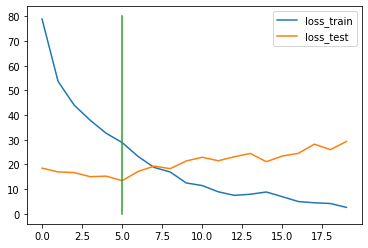

In [ ]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(loss_train, label="loss_train")
plt.plot(loss_test, label="loss_test")
plt.plot([5,5], [0, 80])
plt.legend()
plt.show()

In [ ]:
fix_offset

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
print("classification_report")
print(eval_model(net, test_dataloader))
print("--------------------------------------------------------------")

classification_report
error
              precision    recall  f1-score   support

           0       0.56      0.90      0.69      1185
           1       0.56      0.14      0.23       991

    accuracy                           0.56      2176
   macro avg       0.56      0.52      0.46      2176
weighted avg       0.56      0.56      0.48      2176

--------------------------------------------------------------


In [ ]:
torch.save(net.state_dict(), "/content/drive/My Drive/multi-modal/text_embed_dict.pt")